In [1]:
import cv2 as cv2
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [90]:
# 读取图片和基本数据
savapath = './data0420/'
srcpath = './data0420/11.bmp'
dstpath = './data0420/12.bmp'
src = cv2.imread(srcpath)
dst = cv2.imread(dstpath)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
rows, cols, _ = src.shape

In [91]:
# 采用sift描述子,提取特征
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(src,None)
kp2, des2 = sift.detectAndCompute(dst,None)

# 快速估计最近邻的库匹配
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)
matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
good = sorted(matches, key = lambda x:x.distance)

# 得到求解透视变换的点
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

# 求解模板图像到待检测图像的变换矩阵
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

# 变换矩阵计算得到掩码，然后再次优化输出的匹配点
matchesMask = mask.ravel().tolist()
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=(0, 0, 255), matchesMask=matchesMask[:20])

img = cv2.drawMatches(src,kp1,dst,kp2,good[:20],None,**draw_params)

模板图像到待检测图像的变换矩阵：
 [[ 1.00877105e+00  9.26747189e-03 -2.77522821e+01]
 [-3.56811642e-03  1.00666654e+00 -6.52245565e+01]
 [ 5.53661185e-06  9.58944346e-07  1.00000000e+00]]
待检测图像匹配结果：


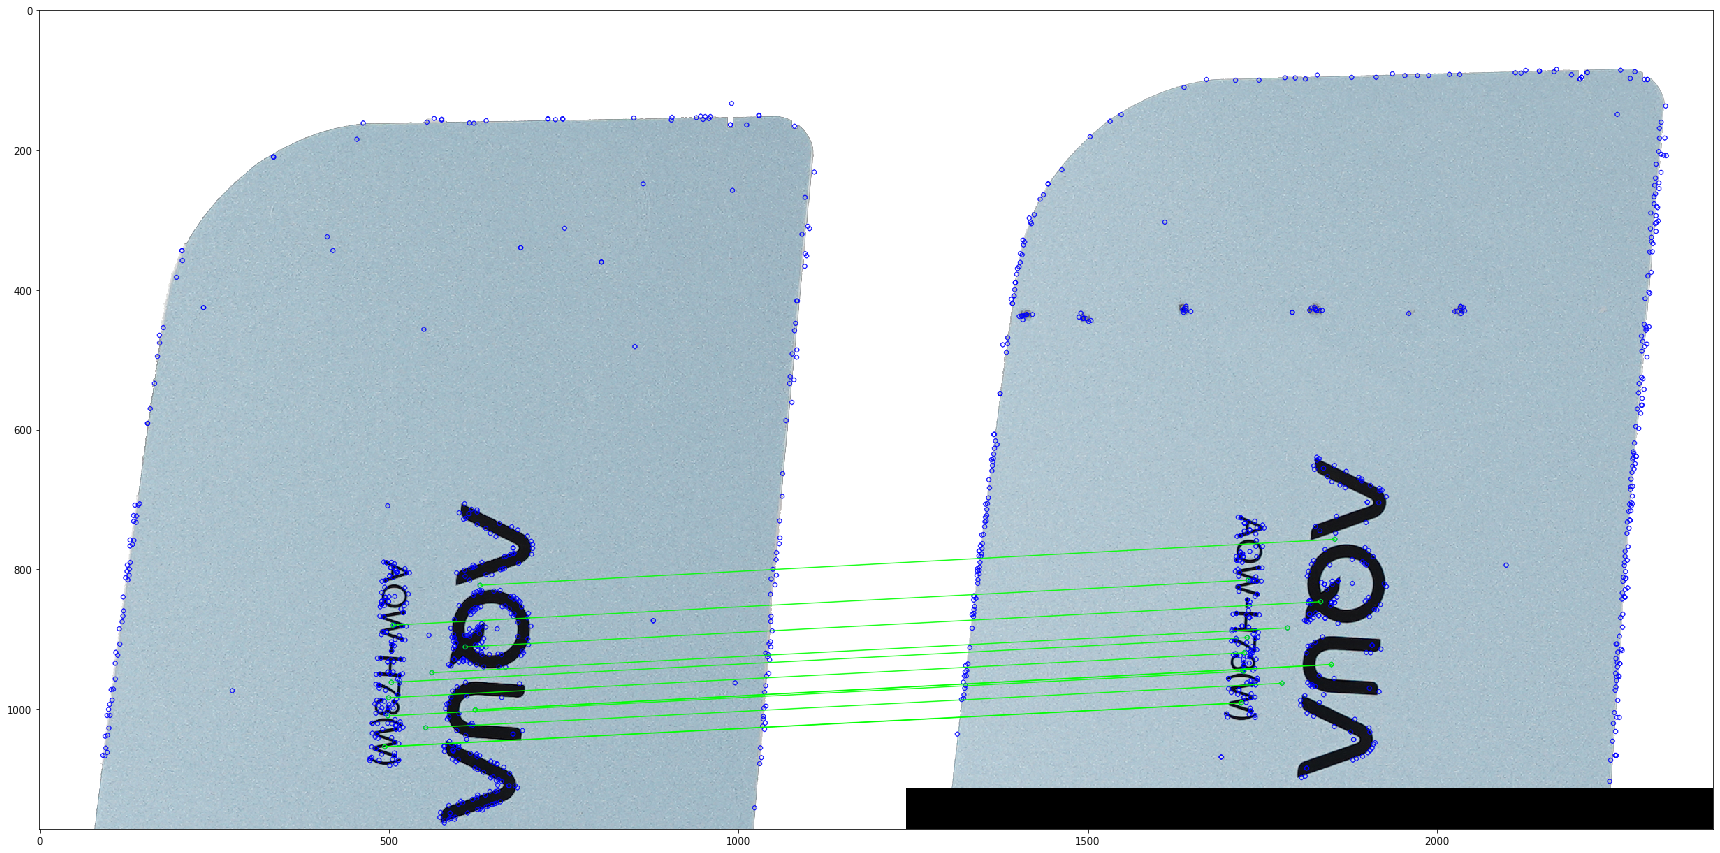

In [108]:
print('模板图像到待检测图像的变换矩阵：\n', M)
print('待检测图像匹配结果：')
plt.figure(figsize=(30, 30))
plt.imshow(img, 'gray')

In [119]:
temp1 = src
temp1 = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)

# cv2.imwrite(savapath+'yuchuli_orign'+srcpath, temp1)

In [120]:
# 将目标图像投射到源图像坐标上，执行了一次M的求逆
result = cv2.warpPerspective(dst, np.mat(M).I, (cols, rows))

temp = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)


test = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

cv2.imwrite(dstpath[:-4]+'peizhun.bmp', temp)

# plt.subplot(4, 2, 2)
# _ = plt.hist(test.reshape(-1), bins=256, density=True,histtype='stepfilled', color='steelblue')


cv2.imwrite(savapath+'yuchuli'+srcpath, test)

False

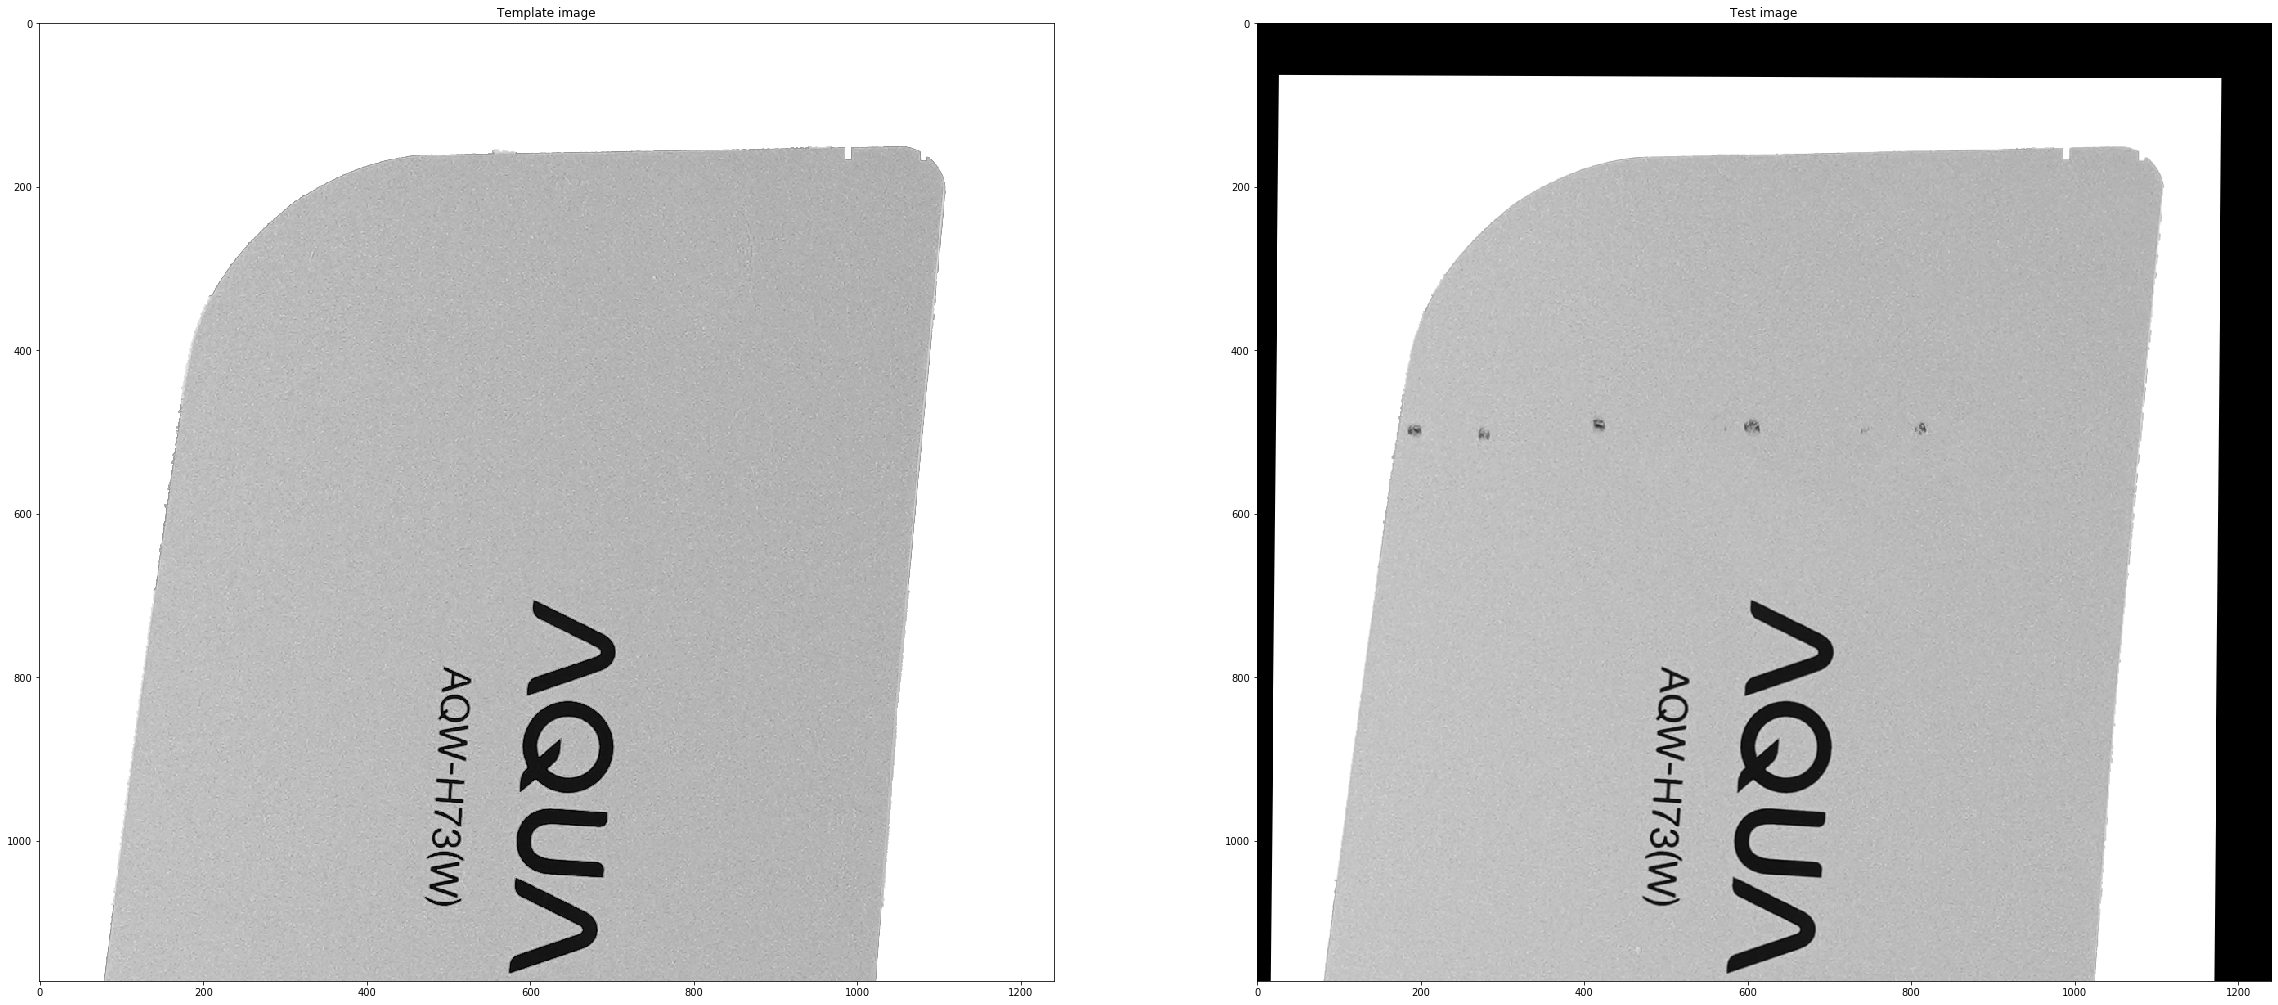

In [118]:
plt.figure(figsize=(40, 40))
plt.subplot(2, 2 , 1)
plt.title('Template image')
plt.imshow(temp1,'gray')

plt.subplot(2, 2, 2)
plt.title('Test image')
plt.imshow(test, 'gray')

[  0   1 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255]


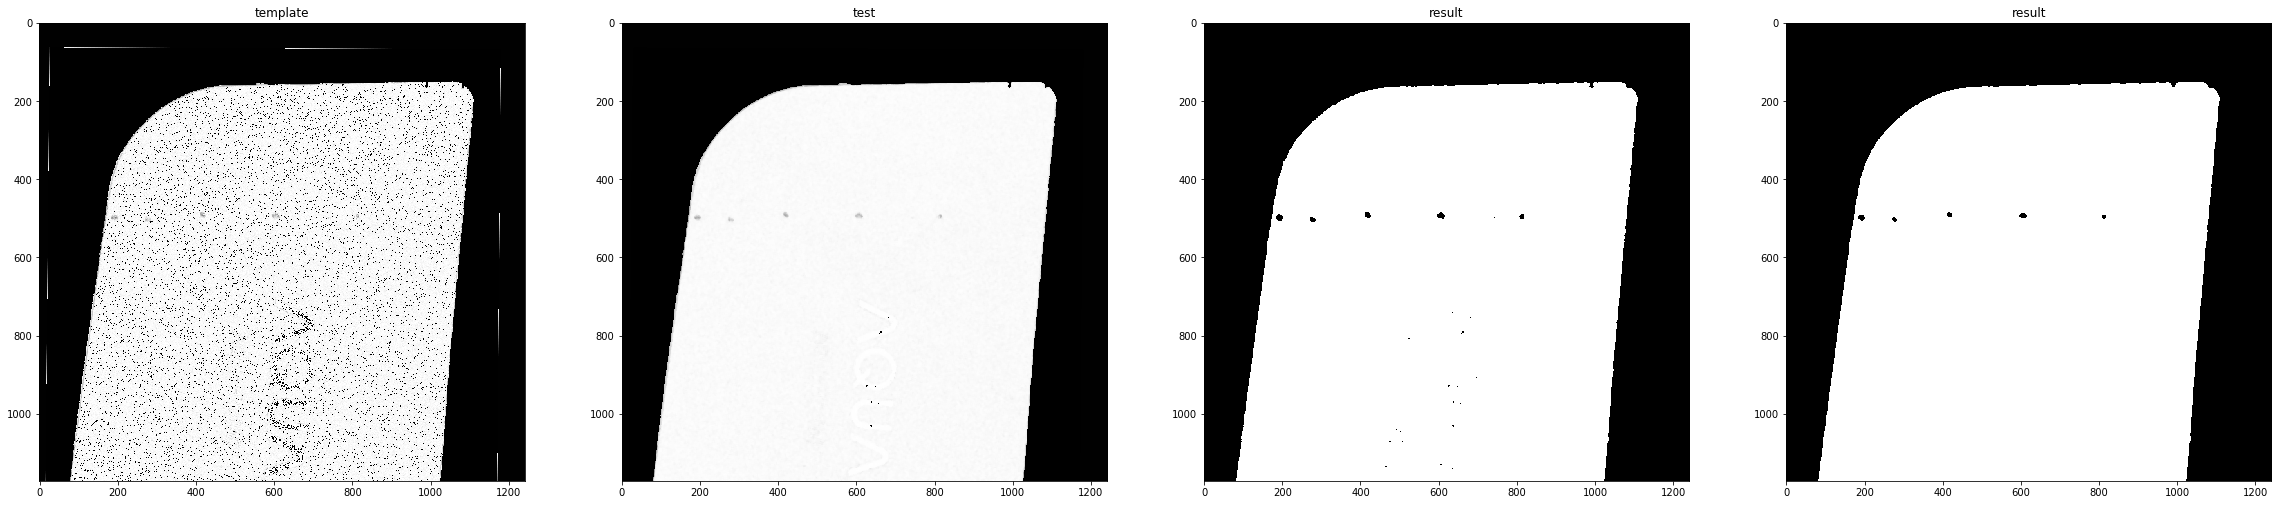

In [107]:
# from skimage.measure import compare_ssim
# (score, diff) = compare_ssim(temp1, test, full=True)

diff = cv2.absdiff(temp1, test)
diff =  (diff * 255).astype("uint8")
fiter = cv2.medianBlur(diff, 7)

print(np.unique(fiter))
# print("SSIM: {}".format(score))
thresh =cv2.threshold(fiter,240,255,0)[1]
fiter2 = cv2.medianBlur(thresh, 11)

# print(diff)
cv2.imwrite(dstpath[:-4]+'diff.bmp', diff)
cv2.imwrite(dstpath[:-4]+'fiter.bmp', fiter)
cv2.imwrite(dstpath[:-4]+'teresh.bmp', thresh)
cv2.imwrite(dstpath[:-4]+'fiter2.bmp', fiter2)

plt.figure(figsize=(40, 40))
plt.subplot(1, 4, 1)
plt.title('template')
plt.imshow(diff,'gray')
plt.subplot(1, 4, 2)
plt.title('test')
plt.imshow(fiter,'gray')
plt.subplot(1, 4, 3)
plt.title('result')
plt.imshow(thresh,'gray')
plt.subplot(1, 4, 4)
plt.title('result')
plt.imshow(fiter2,'gray')

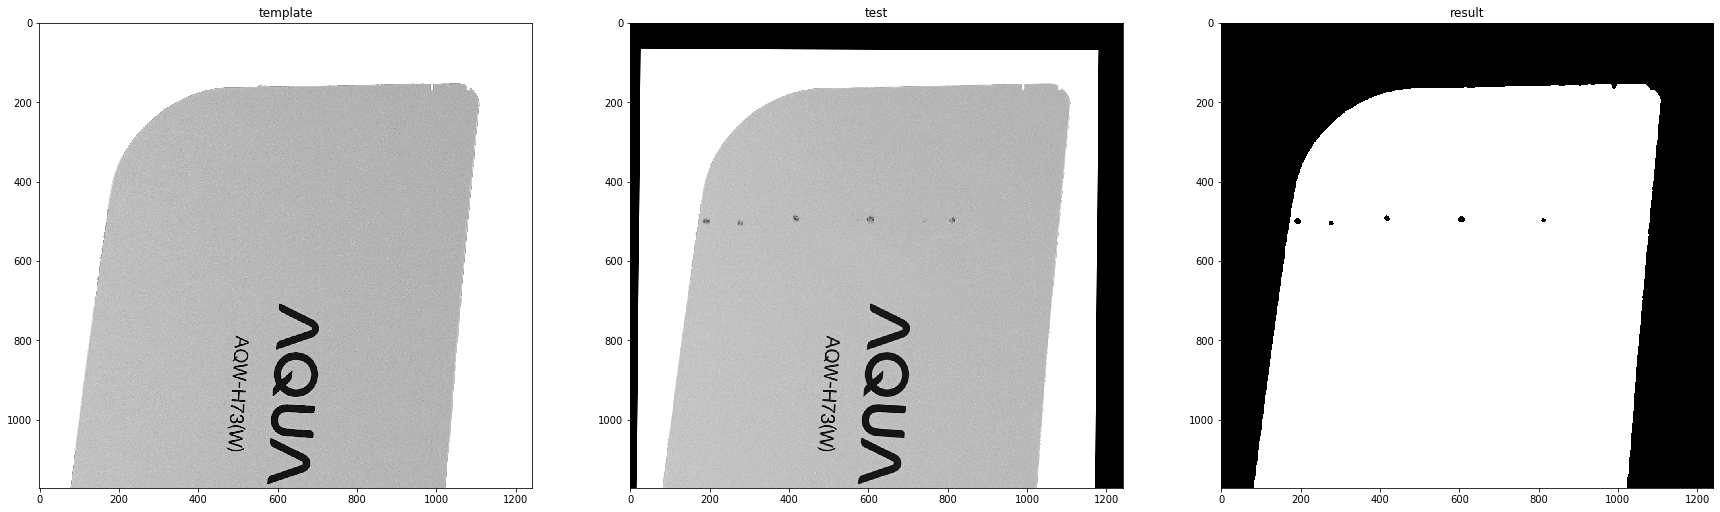

In [98]:
plt.figure(figsize=(30, 30))
plt.subplot(1, 3, 1)
plt.title('template')
plt.imshow(temp1,'gray')
plt.subplot(1, 3, 2)
plt.title('test')
plt.imshow(test,'gray')
plt.subplot(1, 3, 3)
plt.title('result')
plt.imshow(fiter2,'gray')